# Binary Task - Emotion Recognition

In [70]:
import time
import os
import cv2

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import datasets, classifiers and performance metrics
from sklearn import svm, metrics
from sklearn.utils import shuffle
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

%matplotlib inline

# setting user chosen vars
images_dir = './new_dataset'
labels_filename = 'attribute_list.csv'
# user choses grey scale or not, 0 for yes, 1 for no
grey_scale = 1


data_preprocessing: 
- https://datascience.stackexchange.com/questions/26881/data-preprocessing-should-we-normalise-images-pixel-wise
- https://stackoverflow.com/questions/41428868/image-preprocessing-in-deep-learning
- https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258

In [72]:
# Import whole pre-processed Dataset (training and test)

# lists keep the order
full_dataset = []
full_labels = []

# collect labels
df = pd.read_csv(labels_filename, skiprows=1, index_col='file_name')
newdf = df[df.columns[2]] 

# collect pre-processed images and sort them to labels
for (root, dirs, dat_files) in os.walk('{0}'.format(images_dir)):
     
    for file in dat_files:
        # image grayscaling at import
        img = cv2.imread('{0}/{1}'.format(images_dir, file), grey_scale)
        # image equalisation
        # rescaling image (you can use cv2)
        full_dataset.append(img)
        full_labels.append(int(file[:-4]))

# only select rows of interest (none outliers) and only keep 'smiling' feature to be evaluated
full_labels = newdf.ix[full_labels]
full_labels = full_labels.values.tolist() 

# now both of our dataset and labels are ordered 

# numpy array conversion
full_dataset = np.array(full_dataset, dtype=np.float64)
full_labels = np.array(full_labels)

print('full dataset of shape:', full_dataset.shape)
print('full labels of shape:', full_labels.shape)

/Users/brunocalogero/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


full dataset of shape: (4546, 256, 256, 3)
full labels of shape: (4546,)


In [73]:
# Reshuffling data (just in case)
X_data, Y_data = shuffle(full_dataset, full_labels, random_state=0)

print('X_data of shape:', X_data.shape)
print('Y_data of shape:', Y_data.shape)

X_data of shape: (4546, 256, 256, 3)
Y_data of shape: (4546,)


In [74]:
# perform train and test split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)

print('X_train of shape:', X_train.shape)
print('y_train of shape:', y_train.shape)
print('X_test of shape:', X_test.shape)
print('y_test of shape:', y_test.shape)

X_train of shape: (3636, 256, 256, 3)
y_train of shape: (3636,)
X_test of shape: (910, 256, 256, 3)
y_test of shape: (910,)


X_train of shape: (3636, 196608)
X_test of shape: (910, 196608)
[ 185.96067107  190.28850385  194.44444444  186.93014301  191.19829483
  195.45654565  187.81243124  192.0690319   196.30968097  188.42766777]


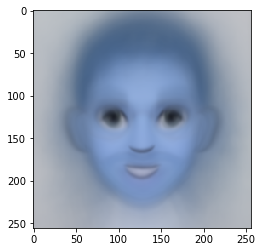

In [75]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print('X_train of shape:', X_train.shape)
print('X_test of shape:', X_test.shape)

# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((256,256,3)).astype('uint8')) # visualize the mean image
plt.show()

In [76]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_test -= mean_image

In [ ]:
classifier = svm.SVC(C=5,kernel='rbf',gamma=0.000001,cache_size=8000,probability=False)

start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

classifier.fit(X_train, y_train)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2018-12-26 03:02:00.926950


In [ ]:
# Now predict the value of the test
expected = y_test
predicted = classifier.predict(X_test)


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
      
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

# plot_confusion_matrix(cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))